# Phishing Model Prototype

In [78]:
%pip install numpy
%pip install pandas
%pip install joblib
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install scipy
%pip install jupyter
%pip install nltk
%pip install num2words
%pip install spacy
!python -m spacy download en_core_web_sm


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------------------------ --------- 9.7/12.8 MB 52.8 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 44.8 MB/s  0:00:00
✔ Download and installation successful
You c

In [79]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin

import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import num2words

import spacy
import sys
!{sys.executable} -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## 1. Data

In [80]:
data = "./data/Nazario_Full.csv"

emails = pd.read_csv(data, sep=",", encoding="UTF-8")

df_emails = emails.copy()

df_emails.shape

(1565, 6)

In [81]:
df_emails.sample(5)

,sender,receiver,date,subject,body,urls
1245,"WeTransfer <noreply@wetransfer.com>,",jose@monkey.org,21 Aug 2020 11:24:34 -0700,jose: You Received Messages/files via WeTransf...,WeTransfer jose@monkey.orgYou have received ...,1
423,"""Wells Fargo""<transfer.alert@wellsfargo.com>",NaN,"Thu, 15 Dec 2016 02:20:28 +0700",Bank-to-Bank Transfers: Transfer Initiated,Your transfer is being processed\n\nTo: CHARLE...,0
13,"""Email Admin"" <no-reply@mailserver.com>",jose@monkey.org,"Thu, 05 Nov 2015 09:51:43 -0500",Auto Email Upgrade jose@monkey.org,Your email ( jose@monkey.org ) is almost full....,1
128,Emails Update <k.strzyz@pronatura.bydgoszcz.pl>,undisclosed-recipients:;,"Thu, 18 Feb 2016 23:37:22 +0100 (CET)",ALL MAILS SECURITY UPDATE,"Hello Sir / madam, The link below contains loc...",0
527,"""Email Administrator"" <upgrade_support@e7marke...",Recipients <upgrade_support@e7marketing.com>,"Sun, 19 Mar 2017 09:27:52 +0100",email-alert@verification.com =?utf-8?Q?=E2=9C=...,Mail Alert!! b11NEC_3ApC8^FA...,1


In [82]:
df_emails.dtypes

sender      object
receiver    object
date        object
subject     object
body        object
urls         int64
dtype: object

## 2. Data Understanding

In [83]:
df_emails.describe()

,urls
count,1565.000000
mean,0.909265
std,0.287323
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


### Emptyness

In [84]:
df_percentages = (100*df_emails.isna().sum()/len(df_emails)).to_frame()
df_percentages.sort_values(0, ascending = False)

,0
receiver,6.134185
subject,0.255591
date,0.063898
sender,0.000000
body,0.000000
urls,0.000000


### Duplicates

In [85]:
df_duplicated = df_emails.loc[df_emails.duplicated(keep=False)]
df_duplicated

,sender,receiver,date,subject,body,urls


## 3. Data Transformations

### Drop Empty & Duplicates

In [86]:
def drop_empty(dataframe):

    dataframe.dropna(inplace=True)

    return

drop_empty(df_emails)

df_emails.shape

(1467, 6)

In [87]:
def drop_duplicates(dataframe):

    dataframe.drop_duplicates(inplace=True)

    return

drop_duplicates(df_emails)
df_emails.shape

(1467, 6)

### Drop Unnecesarry Columns

In [88]:
df_emails.drop(columns=["date"], inplace=True)

### Data Cleaning

In [89]:
def clean_ascii(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)
    df_emails["subject"] = df_emails["subject"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)
    df_emails["body"] = df_emails["body"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)

    return

def clean_upper_case(df_emails):
    df_emails["sender"] = df_emails["sender"].str.lower()
    df_emails["receiver"] = df_emails["receiver"].str.lower()
    df_emails["subject"] = df_emails["subject"].str.lower()
    df_emails["body"] = df_emails["body"].str.lower()

    return

def clean_punctuation(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))
    df_emails["body"] = df_emails["body"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))

    return

def clean_numbers(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))
    df_emails["body"] = df_emails["body"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))

    return

def clena_stopwords(df_emails):
    stop_words = set(stopwords.words('english'))

    df_emails["sender"] = df_emails["sender"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df_emails["body"] = df_emails["body"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    return

def clean_sidebar(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: x.replace("-", " "))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: x.replace("-", " "))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: x.replace("-", " "))
    df_emails["body"] = df_emails["body"].apply(lambda x: x.replace("-", " "))

    return

numbers_post_ascii = r'[0123456789]'

def clean_numbers_post_ascii(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: re.sub(numbers_post_ascii, '', x))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: re.sub(numbers_post_ascii, '', x))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: re.sub(numbers_post_ascii, '', x))
    df_emails["body"] = df_emails["body"].apply(lambda x: re.sub(numbers_post_ascii, '', x))

    return


In [90]:
def clean_text(df_emails):

    clean_ascii(df_emails)
    clean_upper_case(df_emails)
    clean_punctuation(df_emails)
    clean_numbers(df_emails)
    clena_stopwords(df_emails)
    clean_sidebar(df_emails)
    clean_numbers_post_ascii(df_emails)

    return

clean_text(df_emails)
print(df_emails)

                                                 sender  \
1                               cpanel servicecpanelcom   
3                            ann garcia angarciamcoeorg   
4                           usaa usaaacctupdatesccuucom   
5                              utf qpesupport infospcom   
6                                                update   
...                                                 ...   
1560  info advantageapartmentscom infoadvantageapart...   
1561                        monkeyorg helpdeskmonkeyorg   
1562  help center infohelp centercozainfohelp center...   
1563                          metamask infosofamekarcom   
1564  fastway infofastwaycozainfofastwaycozainfofast...   

                               receiver  \
1                         josemonkeyorg   
3           infomaaaaaorg infomaaaaaorg   
4     recipients usaaacctupdatesccuucom   
5                         josemonkeyorg   
6                            recipients   
...                              

### Bag Of Words

In [91]:
def tokenize_text(df_emails):

    df_emails["sender_T"] = df_emails["sender"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])
    df_emails["receiver_T"] = df_emails["receiver"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])
    df_emails["subject_T"] = df_emails["subject"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])
    df_emails["body_T"] = df_emails["body"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])

    return

tokenize_text(df_emails)
print(df_emails)

                                                 sender  \
1                               cpanel servicecpanelcom   
3                            ann garcia angarciamcoeorg   
4                           usaa usaaacctupdatesccuucom   
5                              utf qpesupport infospcom   
6                                                update   
...                                                 ...   
1560  info advantageapartmentscom infoadvantageapart...   
1561                        monkeyorg helpdeskmonkeyorg   
1562  help center infohelp centercozainfohelp center...   
1563                          metamask infosofamekarcom   
1564  fastway infofastwaycozainfofastwaycozainfofast...   

                               receiver  \
1                         josemonkeyorg   
3           infomaaaaaorg infomaaaaaorg   
4     recipients usaaacctupdatesccuucom   
5                         josemonkeyorg   
6                            recipients   
...                              

In [92]:
vectorizer = CountVectorizer()

def vectorize_tokens(df_emails):

    global vectorizer

    email_plain_text = df_emails['sender_T'].astype('str') + ""  + df_emails['receiver_T'].astype('str') + " " + df_emails['subject_T'].astype('str') + " " + df_emails['body_T'].astype('str')

    df_vectorized = vectorizer.fit_transform(email_plain_text)

    return df_vectorized

vectorization = vectorize_tokens(df_emails)
print(vectorization)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 111597 stored elements and shape (1467, 38536)>
  Coords	Values
  (0, 4652)	2
  (0, 34657)	1
  (0, 24601)	1
  (0, 37481)	1
  (0, 392)	2
  (0, 3330)	1
  (0, 37958)	1
  (0, 6437)	1
  (0, 4095)	1
  (0, 36127)	1
  (0, 34690)	1
  (0, 6851)	1
  (0, 3562)	1
  (0, 32050)	1
  (0, 35194)	1
  (0, 37170)	1
  (0, 32065)	2
  (0, 28237)	2
  (0, 33026)	1
  (0, 4371)	1
  (0, 4064)	1
  (0, 28002)	1
  (0, 28239)	1
  (0, 19806)	1
  (0, 34598)	1
  :	:
  (1466, 36106)	2
  (1466, 30959)	3
  (1466, 35473)	3
  (1466, 34871)	6
  (1466, 34539)	3
  (1466, 37779)	7
  (1466, 33584)	3
  (1466, 30543)	3
  (1466, 34863)	4
  (1466, 31571)	3
  (1466, 32223)	3
  (1466, 35492)	3
  (1466, 31486)	9
  (1466, 10859)	2
  (1466, 20131)	2
  (1466, 4599)	6
  (1466, 31521)	6
  (1466, 35568)	3
  (1466, 35970)	2
  (1466, 35360)	2
  (1466, 1746)	2
  (1466, 24850)	2
  (1466, 2955)	3
  (1466, 12058)	4
  (1466, 19538)	1


In [93]:
def prepare_text(df_emails):

    drop_empty(df_emails)
    #drop_duplicates(df_emails)
    clean_text(df_emails)
    tokenize_text(df_emails)
    X = vectorize_tokens(df_emails)

    return X

In [94]:
X = prepare_text(df_emails)

print(X.shape)

(1467, 38497)


## 4. Unsupervised Model

In [95]:
kmeans_clusters = GaussianMixture(n_components=2, covariance_type='diag', random_state=42)
X_dense = X.toarray()
kmeans_clusters.fit(X_dense)

,n_components,2
,covariance_type,'diag'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


In [96]:
labels = kmeans_clusters.predict(X_dense)
print(labels)

[1 1 1 ... 1 1 1]


<Axes: xlabel='Cluster_KMeans'>

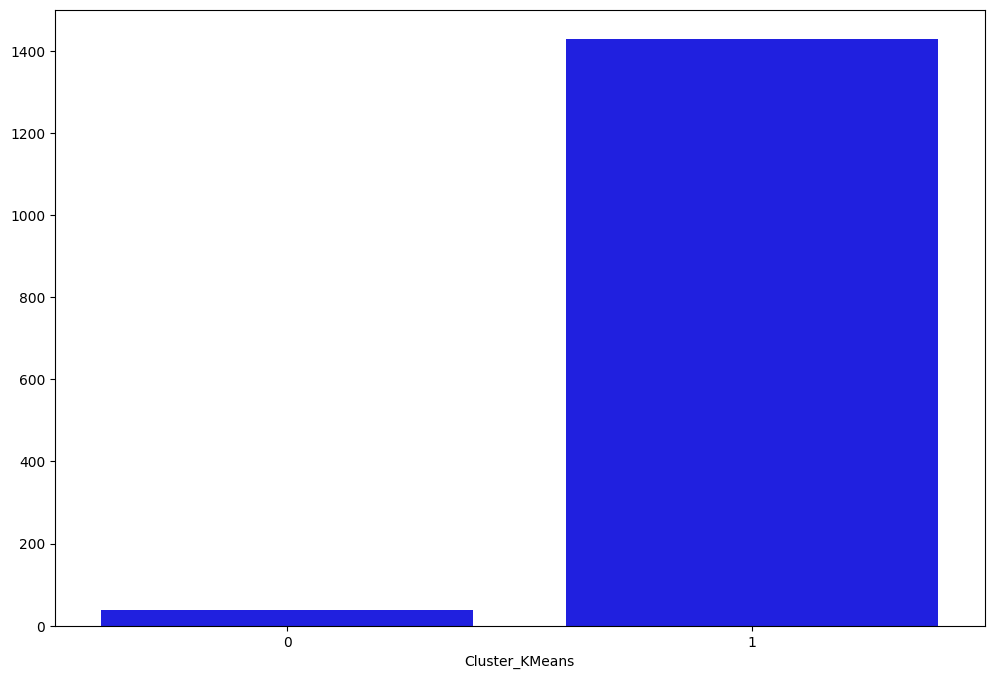

In [97]:
df_kmeans = df_emails.copy()
df_kmeans["Cluster_KMeans"] = labels

cluster_distrib_kmeans = df_kmeans["Cluster_KMeans"].value_counts()

fig=plt.figure(figsize=(12,8))
sns.barplot(x=cluster_distrib_kmeans.index, y=cluster_distrib_kmeans.values, color='b')

## 5. Graphical Visualization

C:\Users\usuario\AppData\Local\Temp\ipykernel_5672\3020809990.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


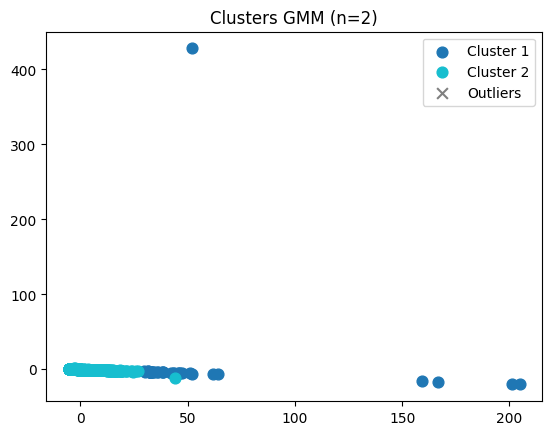

In [98]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X.toarray())

unique_labels = set(labels)
n_clusters = len([l for l in unique_labels if l != -1])

colors = plt.cm.get_cmap('tab10', n_clusters)
for i, label in enumerate([l for l in unique_labels if l != -1]):
    plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1],
                s=60, marker='o', color=colors(i), label=f'Cluster {label+1}')

plt.scatter(X_pca[labels == -1, 0], X_pca[labels == -1, 1],
            s=60, marker='x', color='grey', label='Outliers')

plt.title(f'Clusters GMM (n={n_clusters})')
plt.legend()
plt.show()

## 6. Embeddings Model

In [99]:
def get_email_embeddings(df_emails):
    texts = (
        df_emails["sender"].astype(str) + " " +
        df_emails["receiver"].astype(str) + " " +
        df_emails["subject"].astype(str) + " " +
        df_emails["body"].astype(str) + " " +
        df_emails["urls"].astype(str)
    )
    embeddings = np.array([nlp(text).vector for text in texts])
    return embeddings

In [100]:
clean_text(df_emails)

Y = get_email_embeddings(df_emails)
print(Y.shape)

(1467, 96)


In [101]:
kmeans_clusters_v2 = GaussianMixture(n_components=2, covariance_type='diag', random_state=42)
kmeans_clusters_v2.fit(Y)

,n_components,2
,covariance_type,'diag'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


In [102]:
labels = kmeans_clusters_v2.predict(Y)
print(labels)

[0 0 0 ... 0 0 0]


<Axes: xlabel='Cluster_KMeans'>

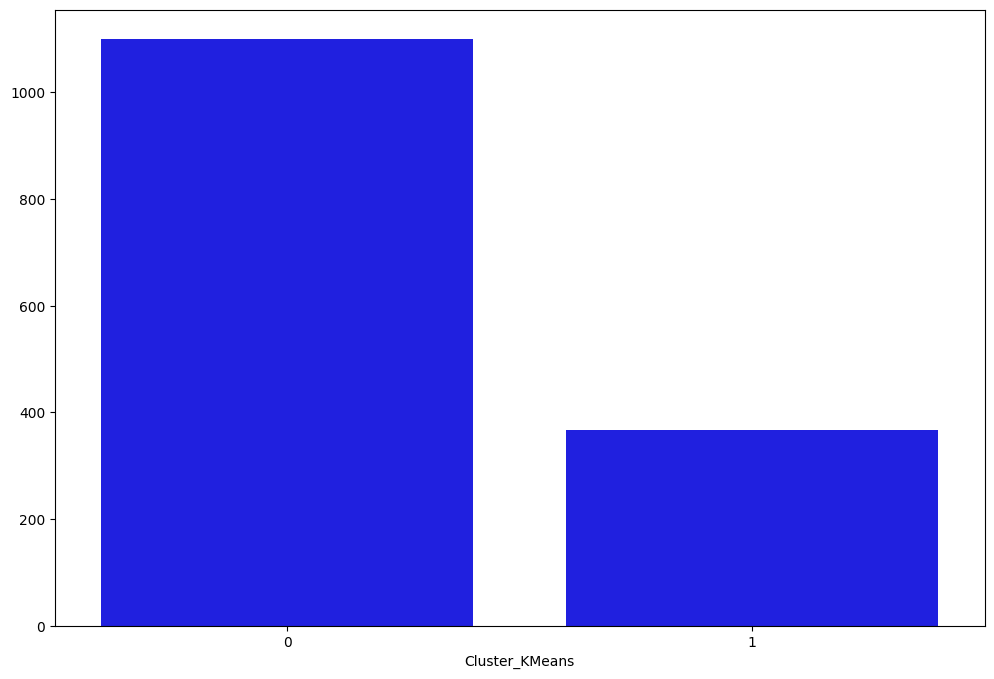

In [103]:
df_kmeans = df_emails.copy()
df_kmeans["Cluster_KMeans"] = labels

cluster_distrib_kmeans = df_kmeans["Cluster_KMeans"].value_counts()

fig=plt.figure(figsize=(12,8))
sns.barplot(x=cluster_distrib_kmeans.index, y=cluster_distrib_kmeans.values, color='b')

## 7. Embeddings Graphical Visualization

C:\Users\usuario\AppData\Local\Temp\ipykernel_5672\734604999.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


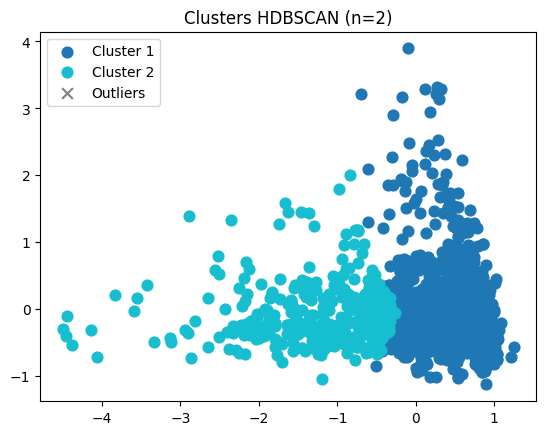

In [104]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(Y)

unique_labels = set(labels)
n_clusters = len([l for l in unique_labels if l != -1])

colors = plt.cm.get_cmap('tab10', n_clusters)
for i, label in enumerate([l for l in unique_labels if l != -1]):
    plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1],
                s=60, marker='o', color=colors(i), label=f'Cluster {label+1}')
    
plt.scatter(X_pca[labels == -1, 0], X_pca[labels == -1, 1],
            s=60, marker='x', color='grey', label='Outliers')

plt.title(f'Clusters HDBSCAN (n={n_clusters})')
plt.legend()
plt.show()

## 8. Check the best Number of Clusters

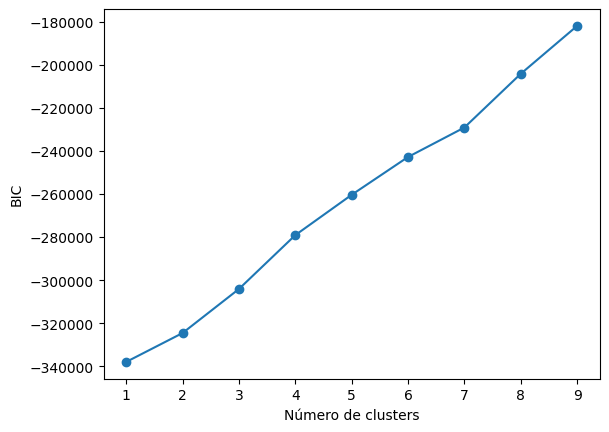

In [105]:
from sklearn.mixture import GaussianMixture

bic = []
n_components_range = range(1, 10)
for k in n_components_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(Y)
    bic.append(gmm.bic(Y))

import matplotlib.pyplot as plt
plt.plot(n_components_range, bic, marker='o')
plt.xlabel("Número de clusters")
plt.ylabel("BIC")
plt.show()

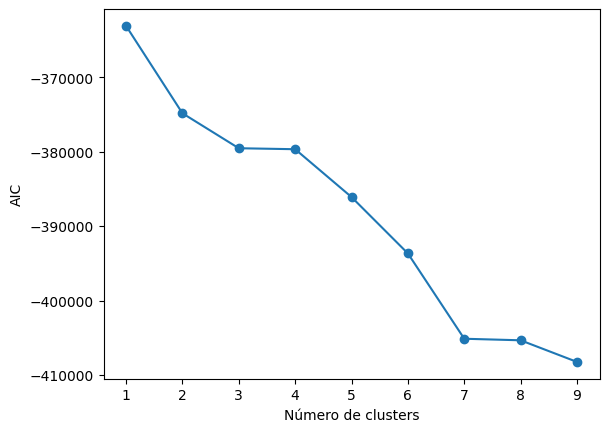

In [106]:
aic = []
for k in n_components_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(Y)
    aic.append(gmm.aic(Y))

plt.plot(n_components_range, aic, marker='o')
plt.xlabel("Número de clusters")
plt.ylabel("AIC")
plt.show()

In [107]:
kmeans_clusters_v2 = GaussianMixture(n_components=4, covariance_type='diag', random_state=42)
kmeans_clusters_v2.fit(Y)

,n_components,4
,covariance_type,'diag'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


In [108]:
labels = kmeans_clusters_v2.predict(Y)
print(labels)

[0 2 1 ... 0 0 0]


<Axes: xlabel='Cluster_KMeans'>

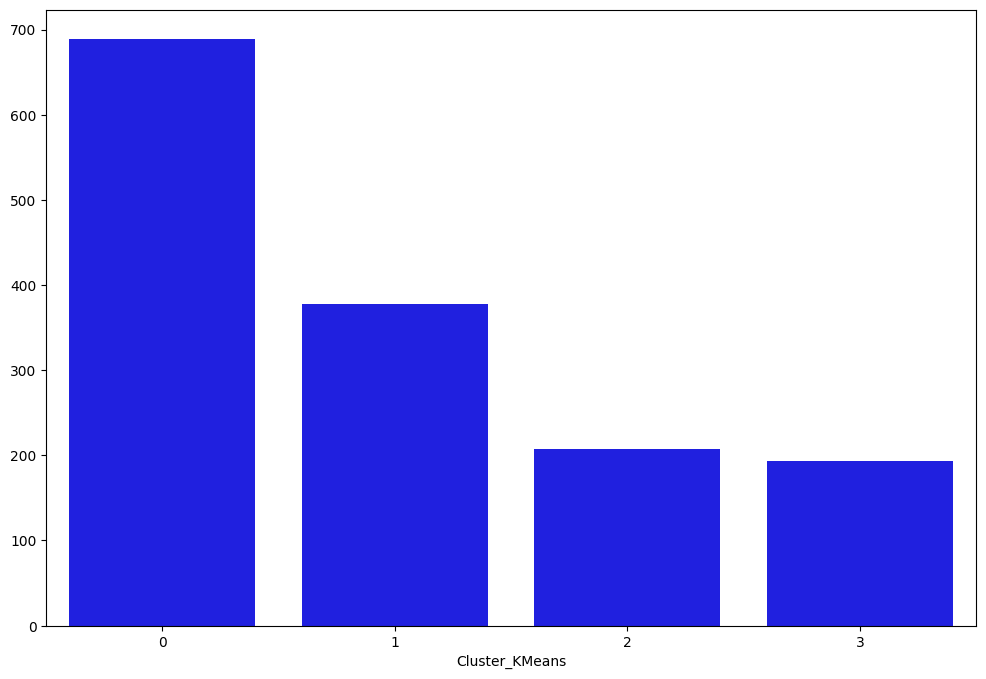

In [109]:
df_kmeans = df_emails.copy()
df_kmeans["Cluster_KMeans"] = labels

cluster_distrib_kmeans = df_kmeans["Cluster_KMeans"].value_counts()

fig=plt.figure(figsize=(12,8))
sns.barplot(x=cluster_distrib_kmeans.index, y=cluster_distrib_kmeans.values, color='b')

C:\Users\usuario\AppData\Local\Temp\ipykernel_5672\1601478158.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


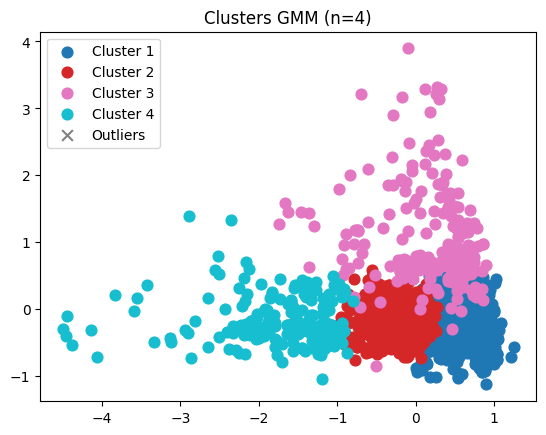

In [111]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(Y)

unique_labels = set(labels)
n_clusters = len([l for l in unique_labels if l != -1])

colors = plt.cm.get_cmap('tab10', n_clusters)
for i, label in enumerate([l for l in unique_labels if l != -1]):
    plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1],
                s=60, marker='o', color=colors(i), label=f'Cluster {label+1}')
    
plt.scatter(X_pca[labels == -1, 0], X_pca[labels == -1, 1],
            s=60, marker='x', color='grey', label='Outliers')

plt.title(f'Clusters GMM (n={n_clusters})')
plt.legend()
plt.show()

## Execution Times

### Aprox 3 Minutes

### Text Processing (BoW & Embeddings) Most Demanding Tasks - 45 sec each